In [1]:
from os.path import join
from itertools import product

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import seaborn as sns
import matplotlib.pyplot as plt

from sharp import ShaRP

from sdv.single_table import TVAESynthesizer
from sdv.metadata import Metadata
from synfair.synthetic_data import SDVGenerator
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LogisticRegression

from mlresearch.utils import set_matplotlib_style

set_matplotlib_style(16)
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})

RANDOM_STATE = 42
N_ROWS = 2000
N_CONT = 4

# (No IG) Create toy dataset

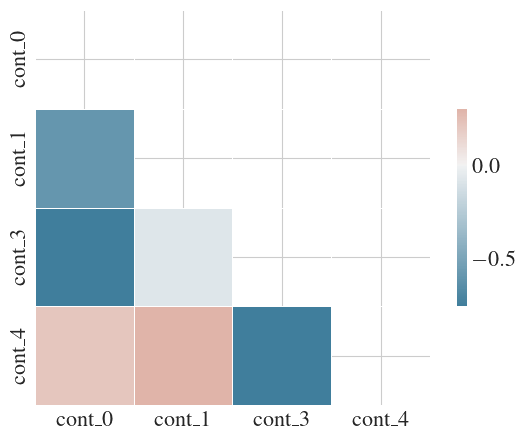

target,0,1
cat,,
adv,113,887
dis,548,452


In [2]:
perc_correlated = .6

X, y = make_classification(
    N_ROWS, 
    N_CONT+1, 
    n_informative=int(perc_correlated*(N_CONT+1)),
    n_redundant=int((1-perc_correlated)*(N_CONT+1)),
    flip_y=0.2,
    weights=[.3],
    random_state=RANDOM_STATE
)

X = pd.DataFrame(X, columns=[f"cont_{i}" for i in range(N_CONT+1)])

# Assign variable with highest correlation to the target to be the categorical (sex) feature
corr_vs_target = X.apply(lambda col: np.corrcoef(col, y)[0, 1])
cat = corr_vs_target.idxmax()
X["cat"] = (X[cat] > (X[cat].median())).astype(int)
X.drop(columns=cat, inplace=True)

# Assign adv/dis labels to categorical feature
conf_matrix = pd.crosstab(X["cat"], pd.Series(y, name="target"))
adv_label = (conf_matrix.loc[:, 1] / conf_matrix.loc[:, 0]).idxmax()
X["cat"] = X["cat"].map(lambda val: "adv" if val == adv_label else "dis")

# Draw the correlation heatmap with the mask and correct aspect ratio
corr = X.corr(numeric_only=True)
sns.heatmap(
    corr, 
    mask=np.triu(np.ones_like(corr, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    vmax=.3, 
    center=0,    
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .5}
)
plt.show()
pd.crosstab(X["cat"], pd.Series(y, name="target"))

In [3]:
# Infer metadata
metadata = Metadata.detect_from_dataframe(data=pd.concat([X, pd.Series(y, name="target")]))
metadata

{
    "tables": {
        "table": {
            "columns": {
                "cont_0": {
                    "sdtype": "numerical"
                },
                "cont_1": {
                    "sdtype": "numerical"
                },
                "cont_3": {
                    "sdtype": "numerical"
                },
                "cont_4": {
                    "sdtype": "numerical"
                },
                "cat": {
                    "sdtype": "categorical"
                },
                "target": {
                    "sdtype": "categorical"
                }
            }
        }
    },
    "relationships": [],
    "METADATA_SPEC_VERSION": "V1"
}

# (No IG) Generate synthetic data + Train classifiers

In [4]:
generator = SDVGenerator(TVAESynthesizer, model_params={"enforce_min_max_values": False, "enforce_rounding": False}, metadata=metadata.to_dict())
generator.fit(X, pd.Series(y, name="target"))

SDVGenerator(metadata={'METADATA_SPEC_VERSION': 'V1', 'relationships': [],
                       'tables': {'table': {'columns': {'cat': {'sdtype': 'categorical'},
                                                        'cont_0': {'sdtype': 'numerical'},
                                                        'cont_1': {'sdtype': 'numerical'},
                                                        'cont_3': {'sdtype': 'numerical'},
                                                        'cont_4': {'sdtype': 'numerical'},
                                                        'target': {'sdtype': 'categorical'}}}}},
             model=<class 'sdv.single_table.ctgan.TVAESynthesizer'>,
             model_params={'enforce_min_max_values': False,
                           'enforce_rounding': False})

In [5]:
X_synth, y_synth = generator.resample(N_ROWS)

In [6]:
model = make_pipeline(
    ColumnTransformer(
        [("OHE", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False), ["cat"])],
        remainder=StandardScaler(),
        force_int_remainder_cols=False
    ),
    LogisticRegression(random_state=RANDOM_STATE)
)
model.fit(X_synth, y_synth)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=StandardScaler(),
                                   transformers=[('OHE',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['cat'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

# (No IG) Overall Analysis

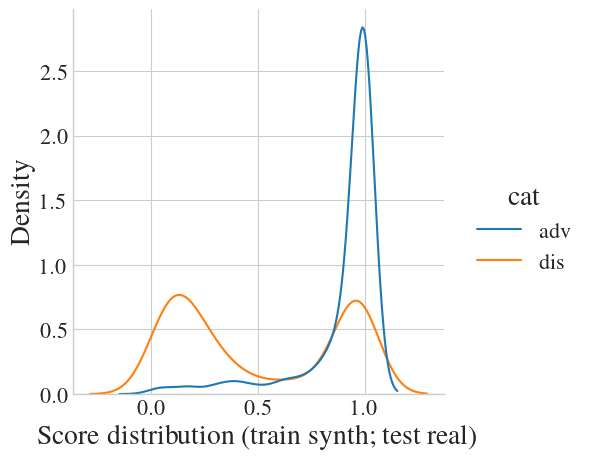

In [7]:
df = X.copy()
df["scores"] = model.predict_proba(X)[:, 1]
df["prediction"] = model.predict(X)
df["target"] = y

sns.displot(df, x="scores", hue="cat", kind="kde")
plt.xlabel("Score distribution (train synth; test real)")
plt.savefig(join("figures", f"overall_dist"))
plt.show()

In [8]:
# Get incorrect predictions
incorrect_mask = df["prediction"] != df["target"]
pd.crosstab(df[incorrect_mask]["cat"], df[incorrect_mask]["prediction"])

prediction,0,1
cat,,
adv,66,107
dis,61,53


In [9]:
# Get correct predictions
incorrect_mask = df["prediction"] == df["target"]
pd.crosstab(df[incorrect_mask]["cat"], df[incorrect_mask]["prediction"])

prediction,0,1
cat,,
adv,6,821
dis,495,391


# (No IG) Get feature importance

In [ ]:
xai = ShaRP(
    qoi="diff",
    target_function=lambda x: model.predict(pd.DataFrame(x.reshape(-1, len(X.columns)), columns=X.columns)),
    verbose=1,
    n_jobs=-1
)
xai.fit(X_synth.values)

In [11]:
# Randomly sample 200 points and get explanations for these
rng = np.random.default_rng(42)
idx = rng.choice(range(X.shape[0]), size=200, replace=False)
X_sample = X.iloc[idx]
y_sample = y[idx]

df_sample = X_sample.copy()
df_sample["scores"] = model.predict_proba(X_sample)[:, 1]
df_sample["prediction"] = model.predict(X_sample)
df_sample["target"] = y_sample

contributions = pd.DataFrame(xai.all(X_sample), index=X_sample.index, columns=X_sample.columns)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
# Get incorrect predictions
incorrect_mask = df_sample["prediction"] != df_sample["target"]
pd.crosstab(df_sample[incorrect_mask]["cat"], df_sample[incorrect_mask]["prediction"])

prediction,0,1
cat,,
adv,5,10
dis,7,3


In [13]:
# Get correct predictions
correct_mask = df_sample["prediction"] == df_sample["target"]
pd.crosstab(df_sample[correct_mask]["cat"], df_sample[correct_mask]["prediction"])

prediction,0,1
cat,,
adv,0,73
dis,58,44


In [41]:
id_uncertain = (df_sample["scores"] - 0.5).abs().sort_values().index[0]
df_sample.loc[id_uncertain]

cont_0       -2.391808
cont_1        2.839488
cont_3        0.327681
cont_4         1.46332
cat                adv
scores        0.540542
prediction           1
target               0
Name: 1287, dtype: object

In [42]:
contributions.loc[id_uncertain]

cont_0   -0.099417
cont_1   -0.073083
cont_3    0.089417
cont_4    0.014833
cat       0.385000
Name: 1287, dtype: float64

In [43]:
df_sample["prediction"].mean()

np.float64(0.65)

In [44]:
xai.feature_names_ = X_sample.columns.values

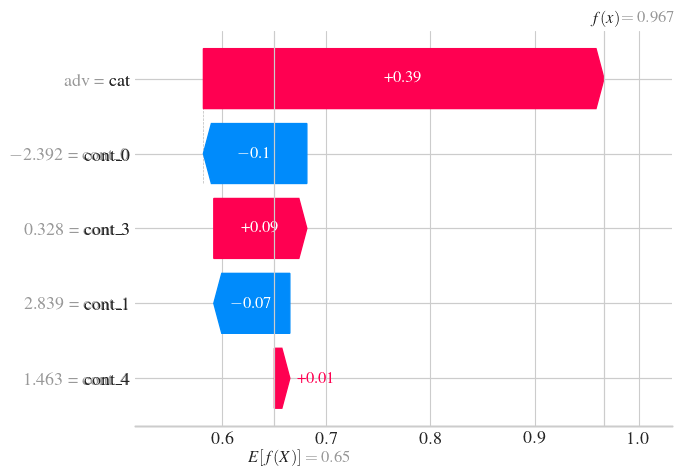

In [45]:
contributions.sum(1) + df_sample["prediction"].mean()
xai.plot.waterfall(
    contributions.loc[id_uncertain].values, 
    X_sample.loc[id_uncertain], 
    mean_target_value=df_sample["prediction"].mean()
)
plt.savefig(join("figures", f"waterfall_uncertain_pred"))
plt.show()

# WITH CONSTRAINTS

In [19]:
scores_no_contraints = df[["scores", "prediction"]].copy()
scores_no_contraints.columns = scores_no_contraints.columns + "_no_const"
df.drop(columns=["scores", "prediction"], inplace=True)
scores_no_contraints

,scores_no_const,prediction_no_const
0,0.999968,1
1,0.332974,0
2,0.999968,1
3,0.202391,0
4,0.875409,1
...,...,...
1995,0.389996,0
1996,0.999369,1
1997,0.999970,1
1998,0.978858,1


In [21]:
model_const = TVAESynthesizer(metadata=metadata, **{"enforce_min_max_values": True, "enforce_rounding": True})
model_const.load_custom_constraint_classes(
    filepath='constraints.py',
    class_names=['CombGreaterThan', 'CombLessThan']
)

cont_cols = df.drop(columns="cat").columns

constraints = []
for operation, col1, col2 in product("+-*", cont_cols, cont_cols):
    constraint = {
        'constraint_class': 'CombGreaterThan',
        'constraint_parameters': {
            'column_names': [col1, col2],
            'operation': operation
        }
    }
    constraints.append(constraint)
    constraint = {
        'constraint_class': 'CombLessThan',
        'constraint_parameters': {
            'column_names': [col1, col2],
            'operation': operation
        }
    }
    constraints.append(constraint)
    
model_const.add_constraints(constraints)
model_const.fit(df)

In [52]:
len(constraints)

150

In [22]:
np.random.seed(RANDOM_STATE)
df_synth_const = model_const.sample(2000)
X_synth_const = df_synth_const.drop(columns="target")
y_synth_const = df_synth_const["target"]

Sampling rows: 100%|████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 19544.02it/s]


In [23]:
clf_const = make_pipeline(
    ColumnTransformer(
        [("OHE", OneHotEncoder(handle_unknown="infrequent_if_exist", sparse_output=False), ["cat"])],
        remainder=StandardScaler(),
        force_int_remainder_cols=False
    ),
    LogisticRegression(random_state=RANDOM_STATE)
)
clf_const.fit(X_synth_const, y_synth_const)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=StandardScaler(),
                                   transformers=[('OHE',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False),
                                                  ['cat'])])),
                ('logisticregression', LogisticRegression(random_state=42))])

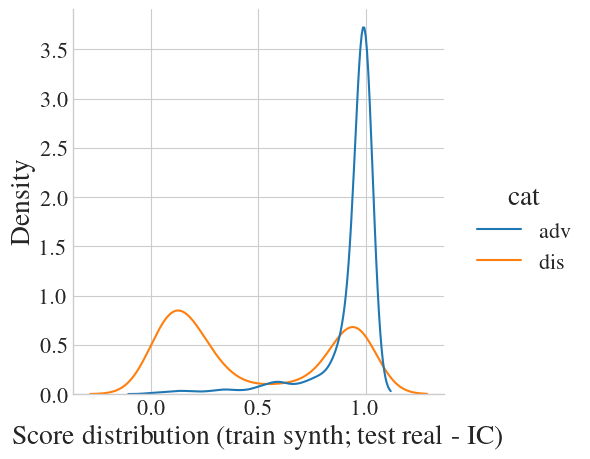

In [24]:
df_const = X.copy()
df_const["scores"] = clf_const.predict_proba(X)[:, 1]
df_const["prediction"] = clf_const.predict(X)
df_const["target"] = y

sns.displot(df_const, x="scores", hue="cat", kind="kde")
plt.xlabel("Score distribution (train synth; test real - IC)")
plt.savefig(join("figures", f"overall_dist_IC"))
plt.show()

In [25]:
# Get incorrect predictions
incorrect_mask_const = df_const["prediction"] != df_const["target"]
pd.crosstab(df_const[incorrect_mask_const]["cat"], df_const[incorrect_mask_const]["prediction"])

prediction,0,1
cat,,
adv,30,109
dis,67,41


In [26]:
# Get correct predictions
incorrect_mask_const = df_const["prediction"] == df_const["target"]
pd.crosstab(df_const[incorrect_mask_const]["cat"], df_const[incorrect_mask_const]["prediction"])

prediction,0,1
cat,,
adv,4,857
dis,507,385


In [27]:
xai_const = ShaRP(
    qoi="diff",
    target_function=lambda x: model.predict(pd.DataFrame(x.reshape(-1, len(X.columns)), columns=X.columns)),
    verbose=1,
    n_jobs=-1
)
xai_const.fit(X_synth_const.values)

In [28]:
# USING THE SAME SAMPLE FROM BEFORE
# Randomly sample 200 points and get explanations for these
# rng = np.random.default_rng(42)
# idx = rng.choice(range(X.shape[0]), size=200, replace=False)
# X_sample = X.iloc[idx]
# y_sample = y[idx]

df_sample_const = X_sample.copy()
df_sample_const["scores_const"] = clf_const.predict_proba(X_sample)[:, 1]
df_sample_const["prediction_const"] = clf_const.predict(X_sample)
df_sample_const["target"] = y_sample

contributions_const = pd.DataFrame(xai_const.all(X_sample), index=X_sample.index, columns=X_sample.columns)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
# Get incorrect predictions
incorrect_mask_const = df_sample_const["prediction_const"] != df_sample_const["target"]
pd.crosstab(df_sample_const[incorrect_mask_const]["cat"], df_sample_const[incorrect_mask_const]["prediction_const"])

prediction_const,0,1
cat,,
adv,3,10
dis,7,3


In [30]:
# Get correct predictions
correct_mask_const = df_sample_const["prediction_const"] == df_sample_const["target"]
pd.crosstab(df_sample_const[correct_mask_const]["cat"], df_sample_const[correct_mask_const]["prediction_const"])

prediction_const,0,1
cat,,
adv,0,75
dis,58,44


In [31]:
# Using the same observation from before
# id_uncertain = (df_sample["scores"] - 0.5).abs().sort_values().index[0]
df_sample_const.loc[id_uncertain]

cont_0             -2.391808
cont_1              2.839488
cont_3              0.327681
cont_4               1.46332
cat                      adv
scores_const        0.724028
prediction_const           1
target                     0
Name: 1287, dtype: object

In [32]:
contributions_const.loc[id_uncertain]

cont_0   -0.105583
cont_1   -0.078667
cont_3    0.088500
cont_4    0.004083
cat       0.368833
Name: 1287, dtype: float64

In [33]:
df_sample_const["prediction_const"].mean()

np.float64(0.66)

In [34]:
xai_const.feature_names_ = X_sample.columns.values

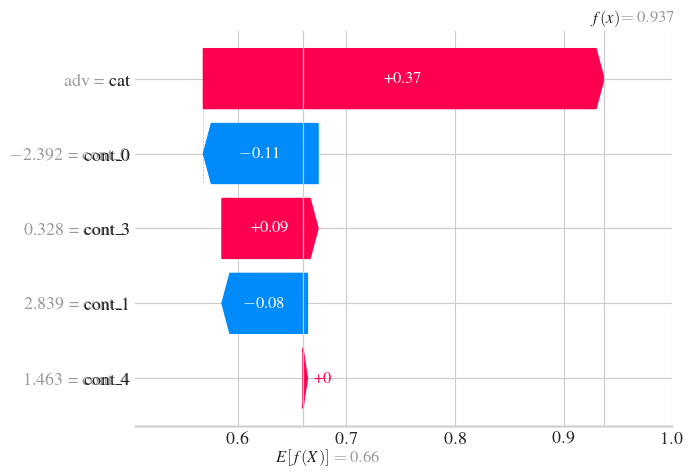

In [50]:
contributions_const.sum(1) + df_sample_const["prediction_const"].mean()
xai_const.plot.waterfall(
    contributions_const.loc[id_uncertain].values, 
    X_sample.loc[id_uncertain], 
    mean_target_value=df_sample_const["prediction_const"].mean()
)
plt.savefig(join("figures", f"waterfall_uncertain_pred_ic"))
plt.show()

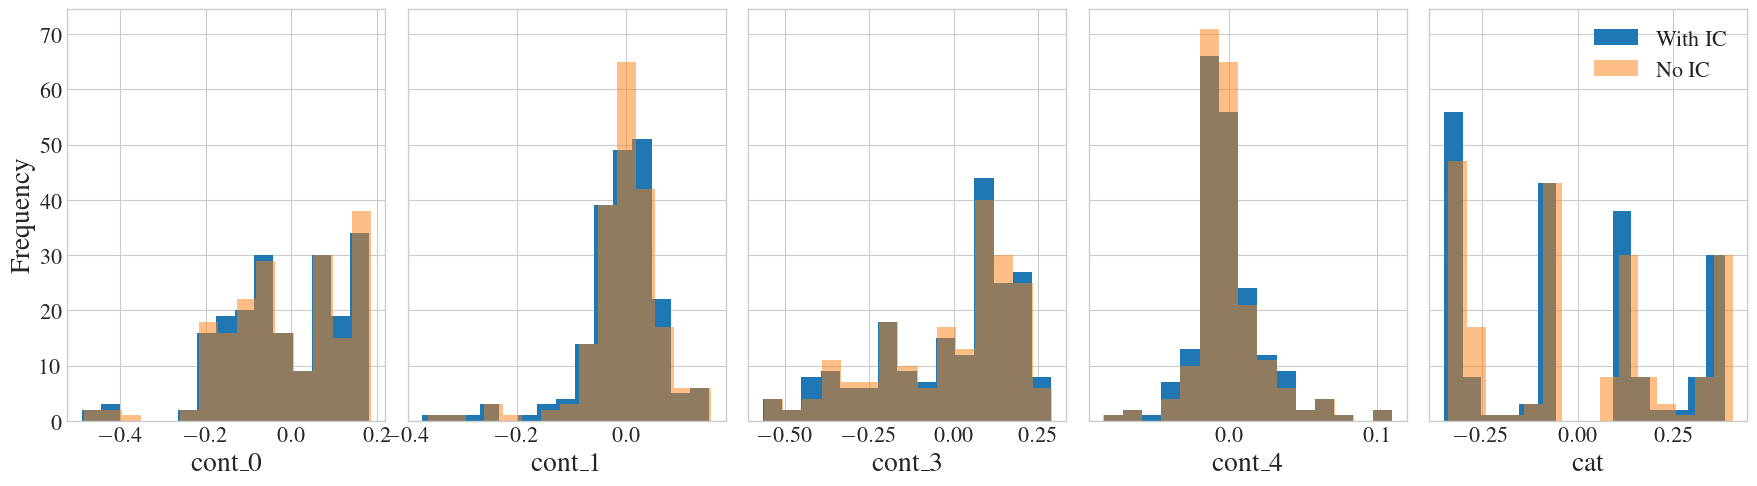

In [36]:
fig, axes = plt.subplots(1, len(contributions.columns), sharey=True, figsize=(20, 5))

for feature, ax in zip(contributions.columns, axes.flatten()):
    contributions_const[feature].plot.hist(label="With IC", bins=15, ax=ax)
    contributions[feature].plot.hist(label="No IC", alpha=0.5, bins=15, ax=ax)
    ax.set_xlabel(feature)

plt.legend()
plt.savefig(join("figures", f"scores_distribution_cat"))
plt.show()

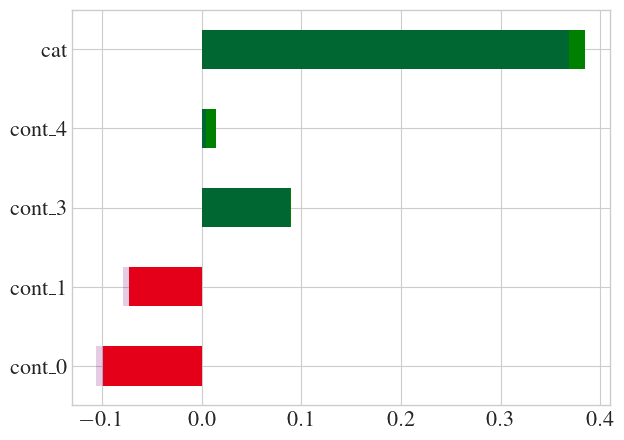

In [37]:
contributions.loc[id_uncertain].plot.barh(color=['green' if x >= 0 else 'red' for x in contributions.loc[id_uncertain]], label="Orig.")
contributions_const.loc[id_uncertain].plot.barh(color=['blue' if x >= 0 else 'purple' for x in contributions_const.loc[id_uncertain]], alpha=.2, label="IC")
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

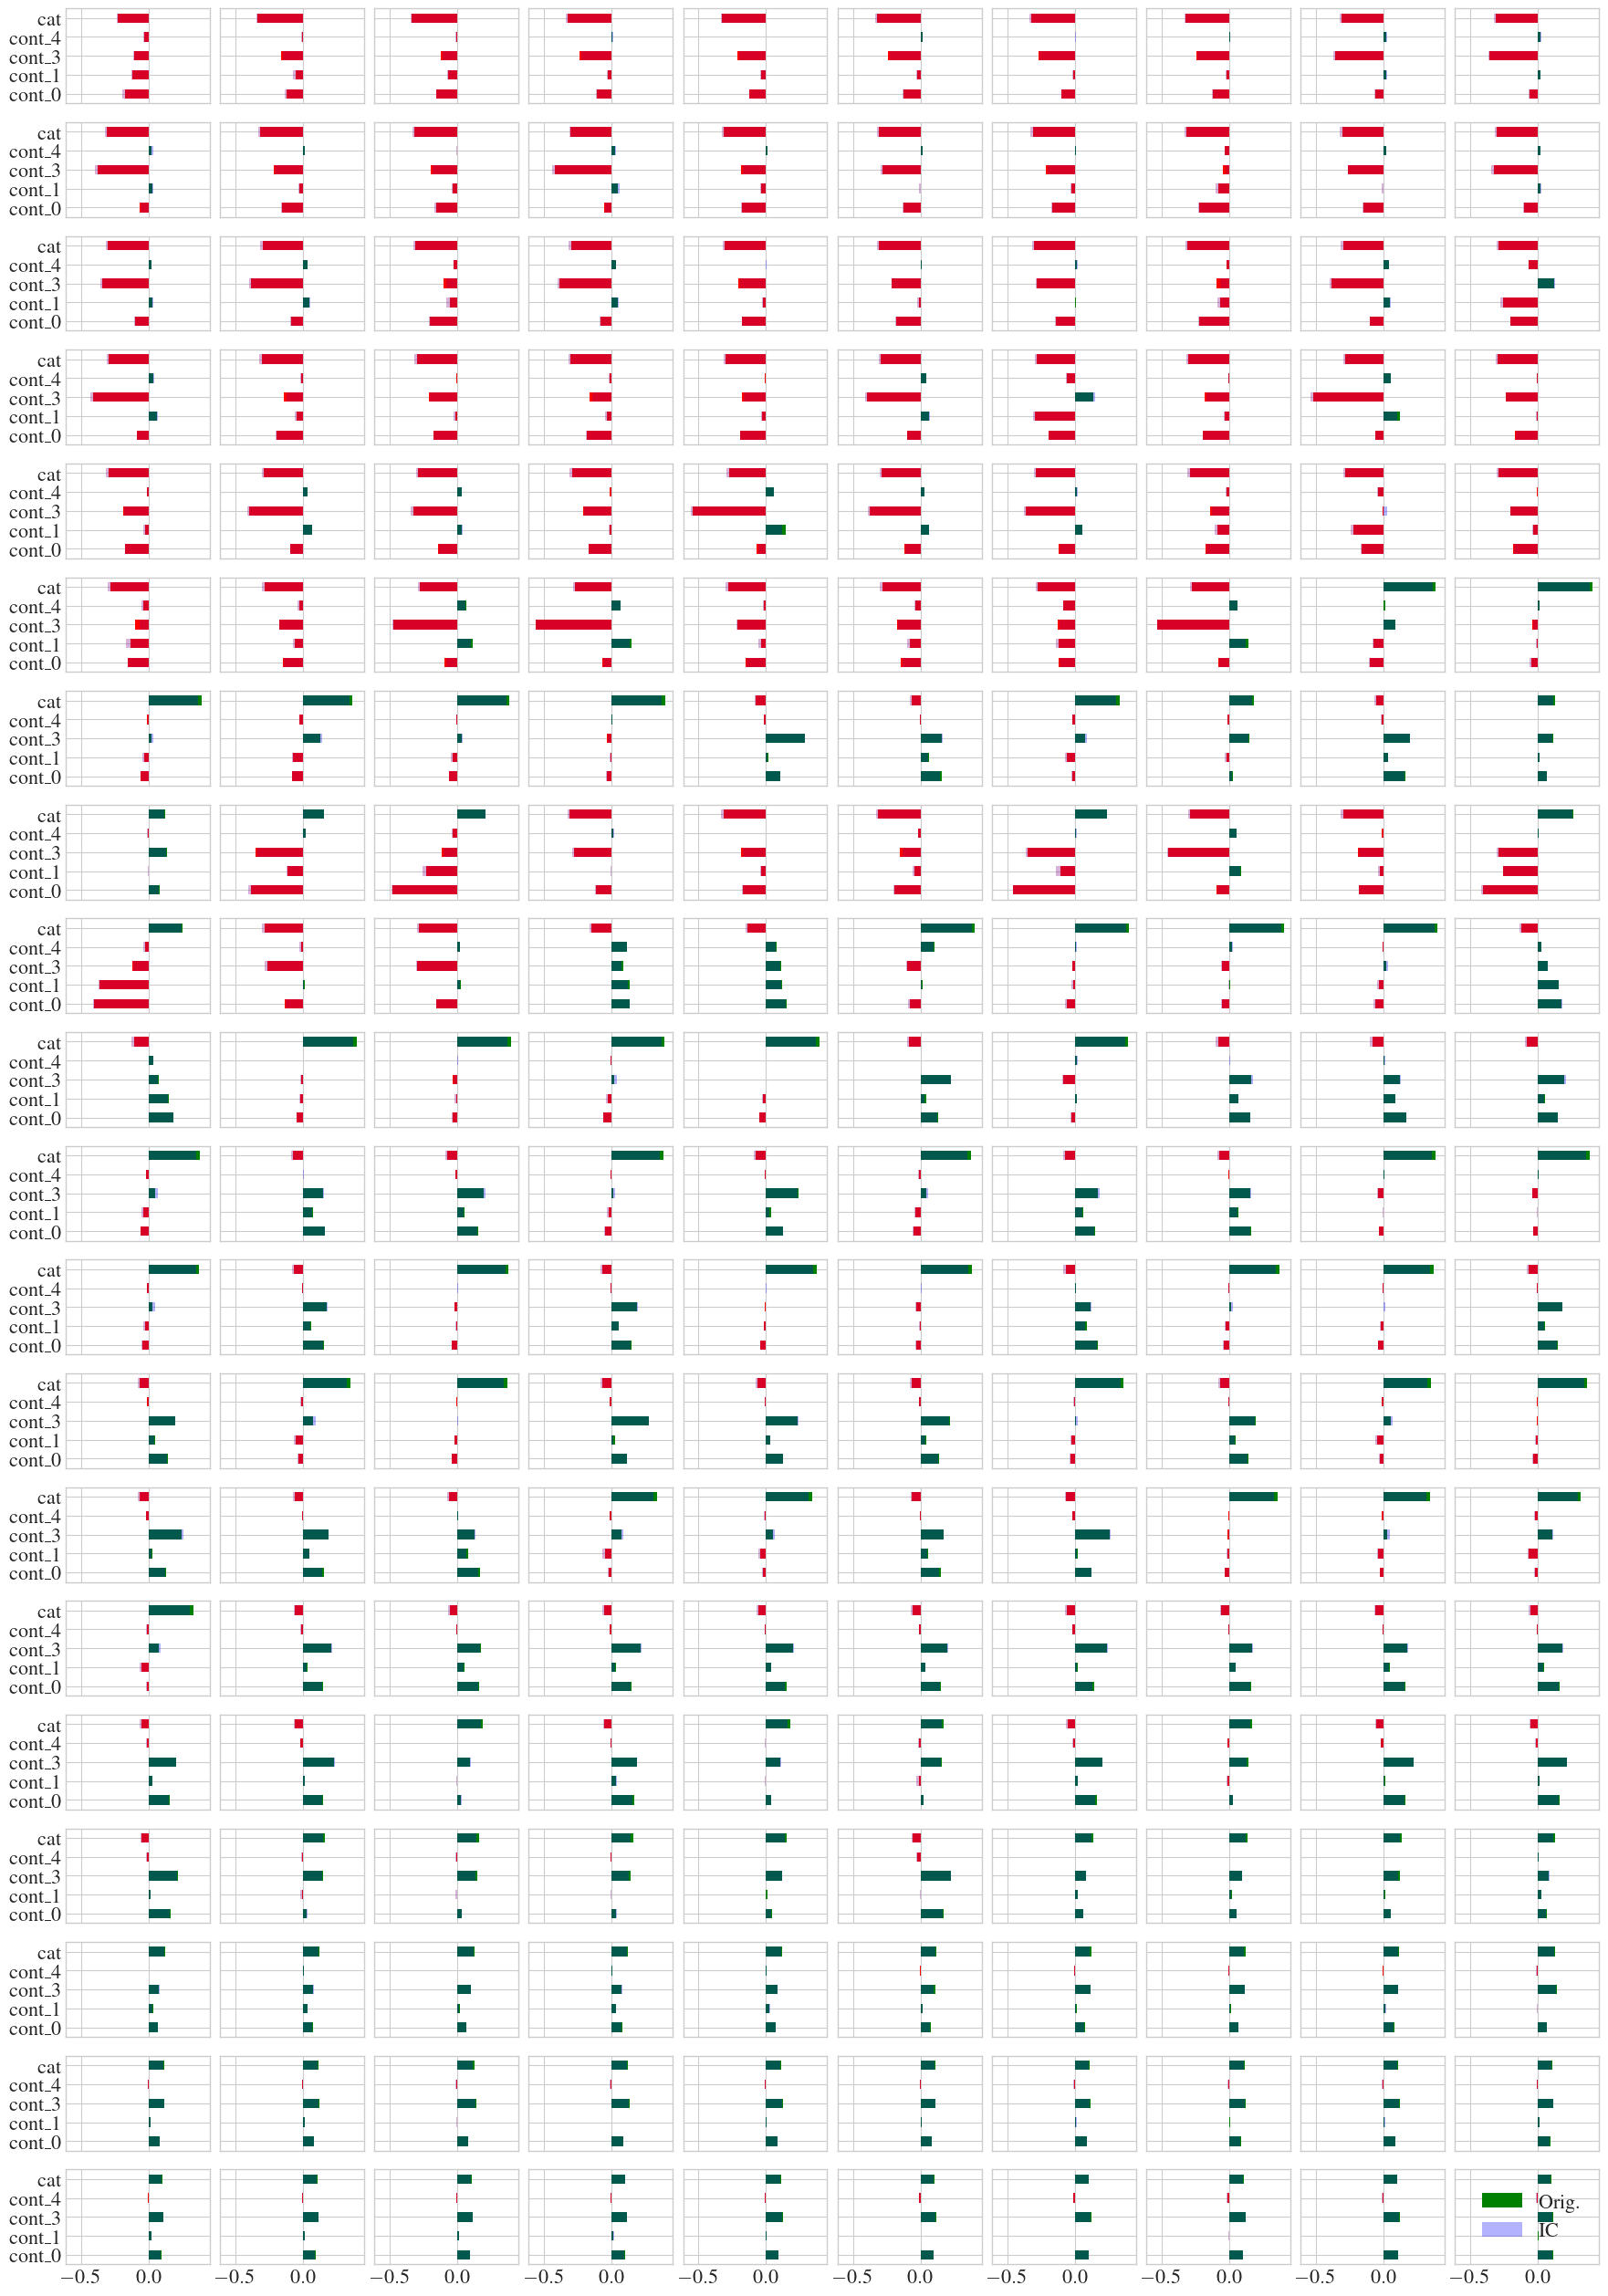

In [51]:
fig, axes = plt.subplots(20, 10, sharex=True, sharey=True, figsize=(20, 30))

ids_sorted = df_sample.sort_values(["target", "scores"]).index
for id_, ax in tqdm(list(zip(ids_sorted, axes.flatten()))):
    # xai_const.plot.bar(contributions.iloc[0], df_sample.iloc[0], mean_target_value=df_sample_const["prediction_const"].mean())
    contributions.loc[id_].plot.barh(color=['green' if x >= 0 else 'red' for x in contributions.loc[id_]], label="Orig.", ax=ax)
    contributions_const.loc[id_].plot.barh(color=['blue' if x >= 0 else 'purple' for x in contributions_const.loc[id_]], alpha=.3, label="IC", ax=ax)

plt.legend()
plt.savefig(join("figures", f"contributions_sample"))
plt.show()

# TEST

In [ ]:
def correlate(X, corr):
    """Creates a modified X based on correlation matrix ``corr``."""
    return y

## Create simulated data

Useful source:
https://stats.stackexchange.com/questions/141427/how-does-the-formula-for-generating-correlated-random-variables-work


In [ ]:
X = rng.uniform(size=(N_ROWS, N_CONT))

# Correlate data
corr = rng.beta(2, 1.5, size=(N_CONT, N_CONT)) * (rng.binomial(1, 0.5, size=(N_CONT, N_CONT))*2 - 1)
np.fill_diagonal(corr, 1)



In [ ]:
(rng.binomial(1, 0.5, size=1000)*2 - 1).sum()

In [ ]:
corr = rng.beta(2, 1.5, size=(N_CONT, N_CONT)) * (rng.binomial(1, 0.5, size=(N_CONT, N_CONT))*2 - 1)
np.fill_diagonal(corr, 1)
corr